In [24]:
import numpy as np
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

hopper_data = defaultdict(dict)
for k in [2, 5]:
    for s in range(5):
        with open('vf_onehot/s%d_k%d_stats.pkl' % (s, k), 'rb') as f:
            hopper_data['%d One-Hot' % k][s] = pickle.load(f)
for k in [2, 5]:
    for s in range(5):
        with open('vf_shared/s%d_k%d_stats.pkl' % (s, k), 'rb') as f:
            hopper_data['%d Shared' % k][s] = pickle.load(f)
            
data_keys = list(hopper_data['5 One-Hot'][0].keys())
print(data_keys)

from pprint import pprint
pprint(hopper_data['5 One-Hot'][0]['program_args'])

['ev_after_y', 'iter_x', 'ev_before_y', 'kl_y_by_head', 'evalrew_x', 'evalrew_head_idx', 'loss_y_by_head', 'program_args', 'rew_x_by_head', 'evalrew_y', 'rew_y_by_head']
{'animate': False,
 'desired_kl': 0.002,
 'eval_every': 10,
 'eval_timesteps': 10000,
 'gamma': 0.99,
 'gym_env': 'Hopper-v1',
 'logdir': '/home/ubuntu/deeprl-proj/log',
 'min_timesteps_per_batch': 25000,
 'n_iter': 300,
 'num_heads': 5,
 'seed': 0,
 'vf_params': {'n_epochs': 25},
 'vf_type': 'nn'}


In [25]:
import pandas as pd

AVG_NBACK = 5

dataframe_data = []
for k, by_seed in sorted(hopper_data.items()):
    for s, data in by_seed.items():
        
        xdata, ydata = data['evalrew_x'], data['evalrew_y']
        
        avg_ydata = np.empty(len(ydata) - AVG_NBACK)
        for i, t in enumerate(range(AVG_NBACK, len(ydata))):
            avg_ydata[i] = np.mean(ydata[t-AVG_NBACK:t])
        avg_xdata = xdata[AVG_NBACK:]
        
        for x, y in zip(avg_xdata, avg_ydata):
            dataframe_data.append((x, y, s, k))

cols = ['time', 'value', 'unit', 'condition']
rew_names = ['Episode', 'Evaluation Reward\nAvg of 50 Episodes', 'unit', 'Num Heads']
hopper_evalrew_df = pd.DataFrame(dataframe_data, columns=rew_names)

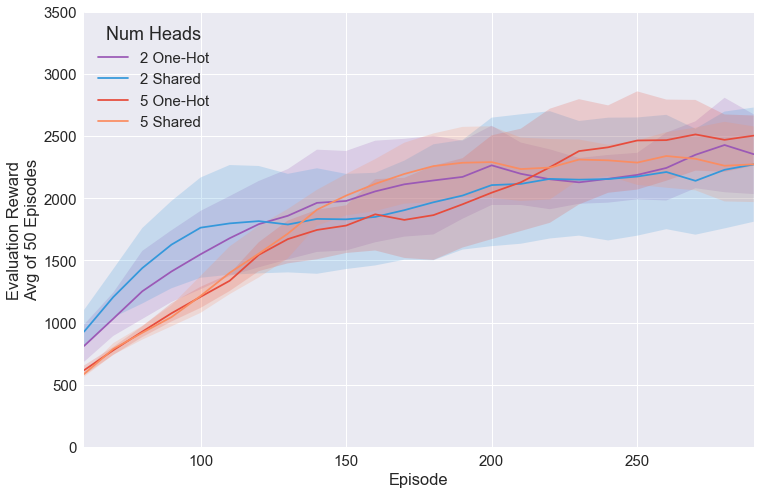

In [27]:
rew_whyseabornwhy = dict(zip(cols, rew_names))
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

flatui = ["#9b59b6", "#3498db", "#e74c3c", "#fa8d62"]
sns.color_palette(flatui).__enter__()
sns.plotting_context('notebook', font_scale=1.5).__enter__()

ax = sns.tsplot(hopper_evalrew_df, ci=[95], ax=ax, **rew_whyseabornwhy)
ax.set_ylim(0, 3500)
ax.legend(title='Num Heads', loc='upper left')
plt.show()

In [28]:
import pandas as pd
from scipy.interpolate import spline

AVG_LEN = 50
SPLINE_POINTS = 250

dataframe_data = []
for k, by_seed in sorted(hopper_data.items()):
    for s, data in by_seed.items():
        ev_x, ev_y = data['iter_x'], data['ev_before_y']
        
        avg_ev_y = np.empty(len(ev_y) - AVG_LEN)
        for i, t in enumerate(range(AVG_LEN, len(ev_y))):
            avg_ev_y[i] = np.mean(ev_y[t-AVG_LEN:t])
        avg_x = ev_x[AVG_LEN:]
        
        spline_x = np.linspace(min(avg_x), max(avg_x), SPLINE_POINTS)
        spline_ev_y = spline(avg_x, avg_ev_y, spline_x)
        
        for x, y in zip(spline_x, spline_ev_y):
            dataframe_data.append((x, y, s, k))

cols = ['time', 'value', 'unit', 'condition']
names = ['Episode', 'Explained Variance (Before Update)\nAvg of 50 Episodes', 'unit', 'Num Heads']
hopper_ev_df = pd.DataFrame(dataframe_data, 
                            columns=names)

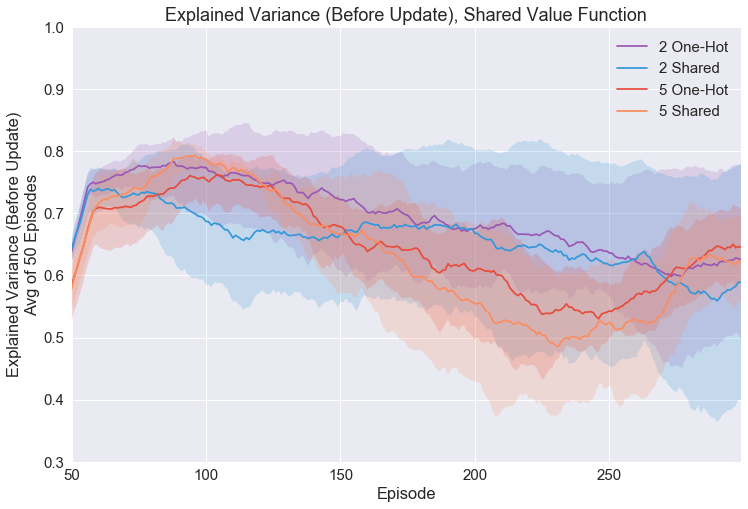

In [29]:
whyseabornwhy = dict(zip(cols, names))
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.tsplot(hopper_ev_df, ci=[95], ax=ax, **whyseabornwhy)
ax.set_ylim(0.3, 1)
ax.set_title('Explained Variance (Before Update), Shared Value Function')
ax.legend(loc='best')
plt.show()

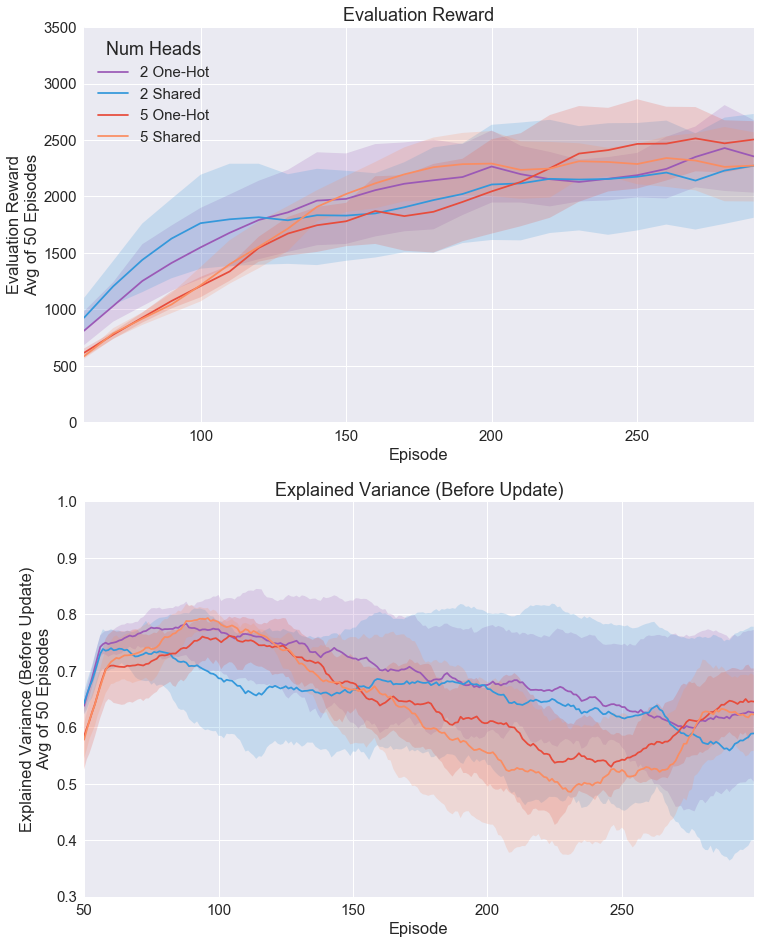

In [38]:
fig, axs = plt.subplots(2, 1, figsize=(12, 16))
rew_ax, ev_ax = axs

sns.plotting_context('notebook', font_scale=1.5).__enter__()
ax = sns.tsplot(hopper_evalrew_df, ci=[95], ax=rew_ax, **rew_whyseabornwhy)
ax.set_ylim(0, 3500)
ax.set_title('Evaluation Reward')
ax.legend(title='Num Heads', loc='upper left')

ax = sns.tsplot(hopper_ev_df, ci=[95], ax=ev_ax, **whyseabornwhy)
ax.set_ylim(0.3, 1)
ax.set_title('Explained Variance (Before Update)')
ax.legend_.remove()
plt.show()